### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import silhouette_score, average_precision_score, f1_score, classification_report

### Importation des données

In [3]:
df = pd.read_csv('../data/default_nyc_taxi.csv')
df.head()

,timestamp,value,class
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


In [4]:
# recupere les anomalies du dataset
with open("../data/labels.json", 'r') as file:
    labels = json.load(file)
    
path = 'realKnownCause/nyc_taxi.csv'
anomaly_points = labels[path]
anomaly_points

[['2014-10-30 15:30:00.000000', '2014-11-03 22:30:00.000000'],
 ['2014-11-25 12:00:00.000000', '2014-11-29 19:00:00.000000'],
 ['2014-12-23 11:30:00.000000', '2014-12-27 18:30:00.000000'],
 ['2014-12-29 21:30:00.000000', '2015-01-03 04:30:00.000000'],
 ['2015-01-24 20:30:00.000000', '2015-01-29 03:30:00.000000']]

### Préparation des données

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp    datetime64[ns]
value                 int64
class                 int64
dtype: object

### Modélisation

In [6]:
# Count the number of anomalies in the data and compute the percentage
anomalies = df['class'].sum()
anomalies_perct = round((anomalies / len(df)) * 100, 2)
print(f"The percentage of anomalies in the dataset is {anomalies_perct}%")

The percentage of anomalies in the dataset is 9.98%


In [7]:
# calculate contamination parameter

anomalies = df['class'].sum()
contamination = anomalies / len(df)
#ou contamination = df["class"].value_counts(normalize=True)[1]

contamination_rounded = round(contamination, 2)

print(contamination)
print(contamination_rounded)

0.0998062015503876
0.1


In [8]:
# Optimize model
def optimize(estimator, hyper_params):

    grid = RandomizedSearchCV(estimator=estimator, param_distributions=hyper_params, scoring='adjusted_rand_score', cv=3, n_iter=100, random_state=42, n_jobs=-1, verbose=3) 
    grid.fit(df[['value']])

    print(grid.best_score_) #Score de la cross val
    print(grid.best_params_) #Meilleurs params

    best_model = grid.best_estimator_
    print(best_model)

    return best_model

In [9]:
# Evaluate the model
def evaluate(estimator, anomalies_predicted):
    print(f"Evaluation for the {estimator}")
    print("")

    print(f"Percentage of anoamlies detected : {round(100*list(df[anomalies_predicted]).count(1)/df.shape[0],3)} %")
    print(f"Percentage of real anomalies : {round(100*list(df['class']).count(1)/df.shape[0],3)} %")
    print("")

    silhouette = round(silhouette_score(df[['value']], df[anomalies_predicted]),2)
    print(f'Silhouette Score : {silhouette}')

    auprc = round(average_precision_score(df['class'], df[anomalies_predicted]),2)
    print(f'AUPRC : {auprc}')

    f1 = round(f1_score(df['class'], df[anomalies_predicted]),2)
    print(f'F1 Score : {f1}')
    print("")

    print(classification_report(df['class'], df[anomalies_predicted]))

    return (silhouette, auprc, f1)

In [10]:
# Display anomalies found
def display_anomalies(estimator, anomalies_predicted):

    plt.figure(figsize = (20, 10))

    # time serie
    sns.lineplot(x='timestamp', y='value', data=df, marker='o', linestyle='', label='Time serie')

    # real anomalies
    first = True
    for start, end in anomaly_points:
        label = 'Anomalies real' if first == True else '_nolegend_'
        sns.lineplot(x='timestamp', y='value', data=df[((df['timestamp'] > start) & (df['timestamp'] < end))], color='orange', marker='o', linestyle='', label=label)
        first = False

    # anomalies found
    sns.lineplot(x='timestamp', y='value', data=df[df[anomalies_predicted] == 1], color='red', marker='o', linestyle='', label='Anomalies found')

    # legend
    plt.title(f'Anomalies detected by {estimator}')
    plt.xlabel('Datetime')
    plt.ylabel('The Number of NYC taxi passengers')
    plt.show()

### Isolation Forest

In [11]:
# Initiate the model optimized
estimator = IsolationForest()

hyper_params = {'n_estimators':[15, 25, 50, 100, 300],
                'max_samples':['auto', 10, 15, 25],
                'contamination':['auto',contamination_rounded,0.1,0.2,0.3,0.4,0.5],
                'random_state': np.linspace(start=1, stop=100, num=20, dtype=int)}

iforest = optimize(estimator, hyper_params)

# Fit and predict the model
iforest_pred = iforest.predict(df[['value']])
df['iforest_pred'] = [1 if i == -1 else 0 for i in iforest_pred] # Change the prediction values to make it consistent with the true values

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Josh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Josh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


nan
{'random_state': 42, 'n_estimators': 300, 'max_samples': 15, 'contamination': 0.1}
IsolationForest(contamination=0.1, max_samples=15, n_estimators=300,
                random_state=42)


In [12]:
# Evaluate the model
iforest_silhouette, iforest_auprc, iforest_f1 = evaluate('Isolation Forest', 'iforest_pred')

Evaluation for the Isolation Forest

Percentage of anoamlies detected : 9.952 %
Percentage of real anomalies : 9.981 %

Silhouette Score : 0.42
AUPRC : 0.1
F1 Score : 0.12

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      9290
           1       0.12      0.12      0.12      1030

    accuracy                           0.83     10320
   macro avg       0.51      0.51      0.51     10320
weighted avg       0.82      0.83      0.82     10320



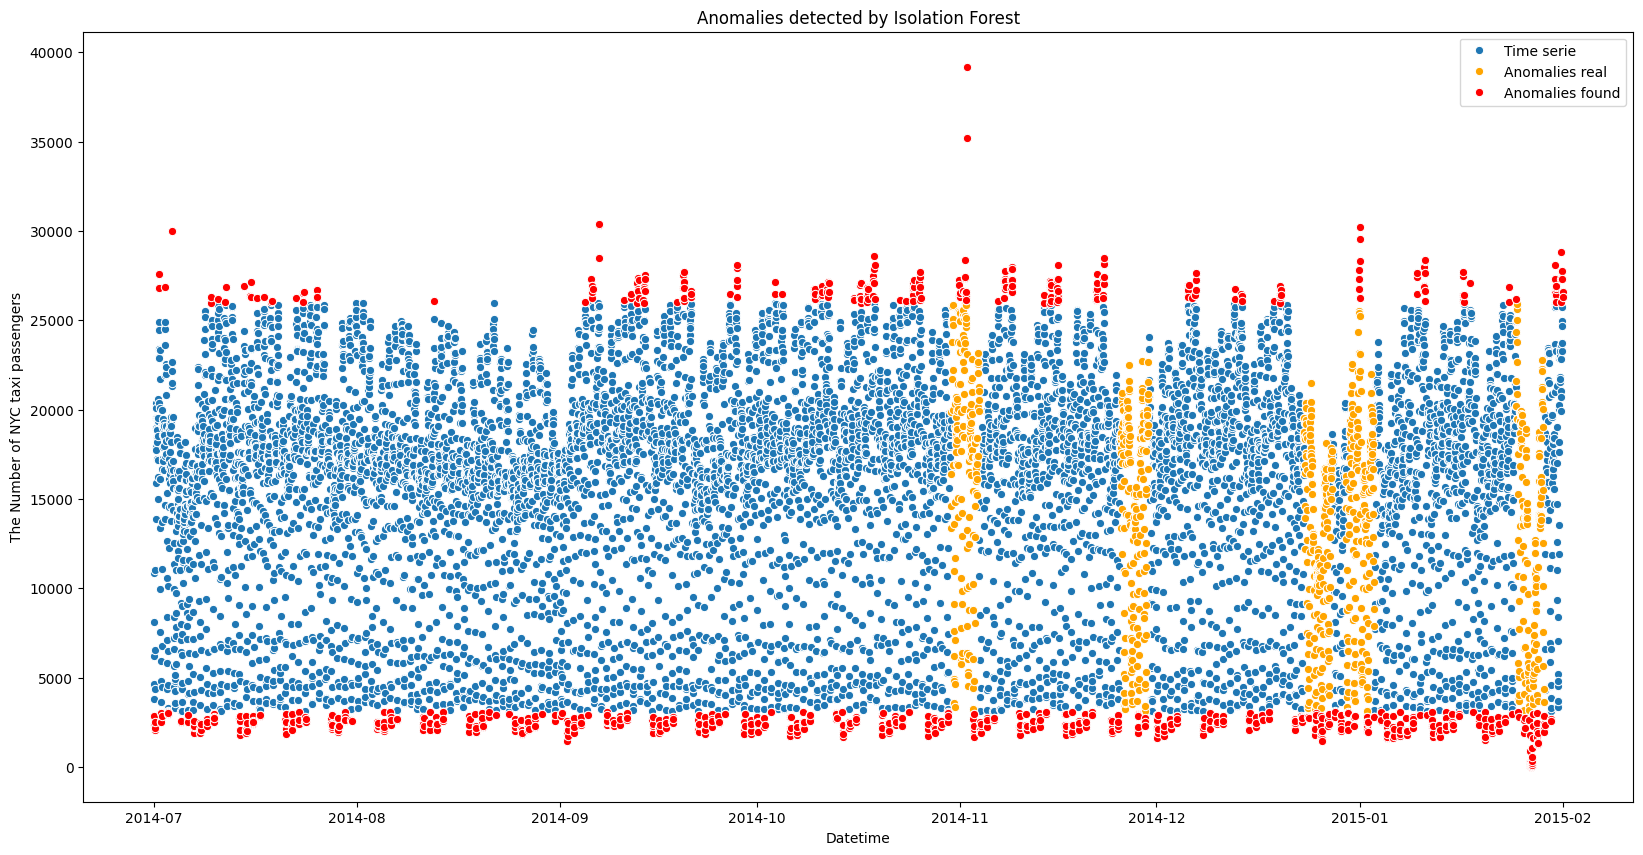

In [13]:
# Display anomalies found
display_anomalies('Isolation Forest', 'iforest_pred')

### Local Outlier Factor

In [14]:
# Initiate the model optimized
estimator = LocalOutlierFactor()

hyper_params = {'n_neighbors':[15, 20, 25],
                'contamination':['auto',contamination_rounded,0.1,0.2,0.3,0.4,0.5],
                'leaf_size': [20, 30, 40, 50]}

lof = optimize(estimator, hyper_params)

# Fit and predict the model
lof_pred = lof.fit_predict(df[['value']])
df['lof_pred'] = [1 if i == -1 else 0 for i in lof_pred] # Change the prediction values to make it consistent with the true values

c:\Users\Josh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 84 is smaller than n_iter=100. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 84 candidates, totalling 252 fits
nan
{'n_neighbors': 15, 'leaf_size': 20, 'contamination': 'auto'}
LocalOutlierFactor(leaf_size=20, n_neighbors=15)


c:\Users\Josh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [15]:
# Evaluate the model
lof_silhouette, lof_auprc, lof_f1 = evaluate('Local Outlier Factor', 'lof_pred')

Evaluation for the Local Outlier Factor

Percentage of anoamlies detected : 0.242 %
Percentage of real anomalies : 9.981 %

Silhouette Score : 0.44
AUPRC : 0.11
F1 Score : 0.03

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9290
           1       0.56      0.01      0.03      1030

    accuracy                           0.90     10320
   macro avg       0.73      0.51      0.49     10320
weighted avg       0.87      0.90      0.86     10320



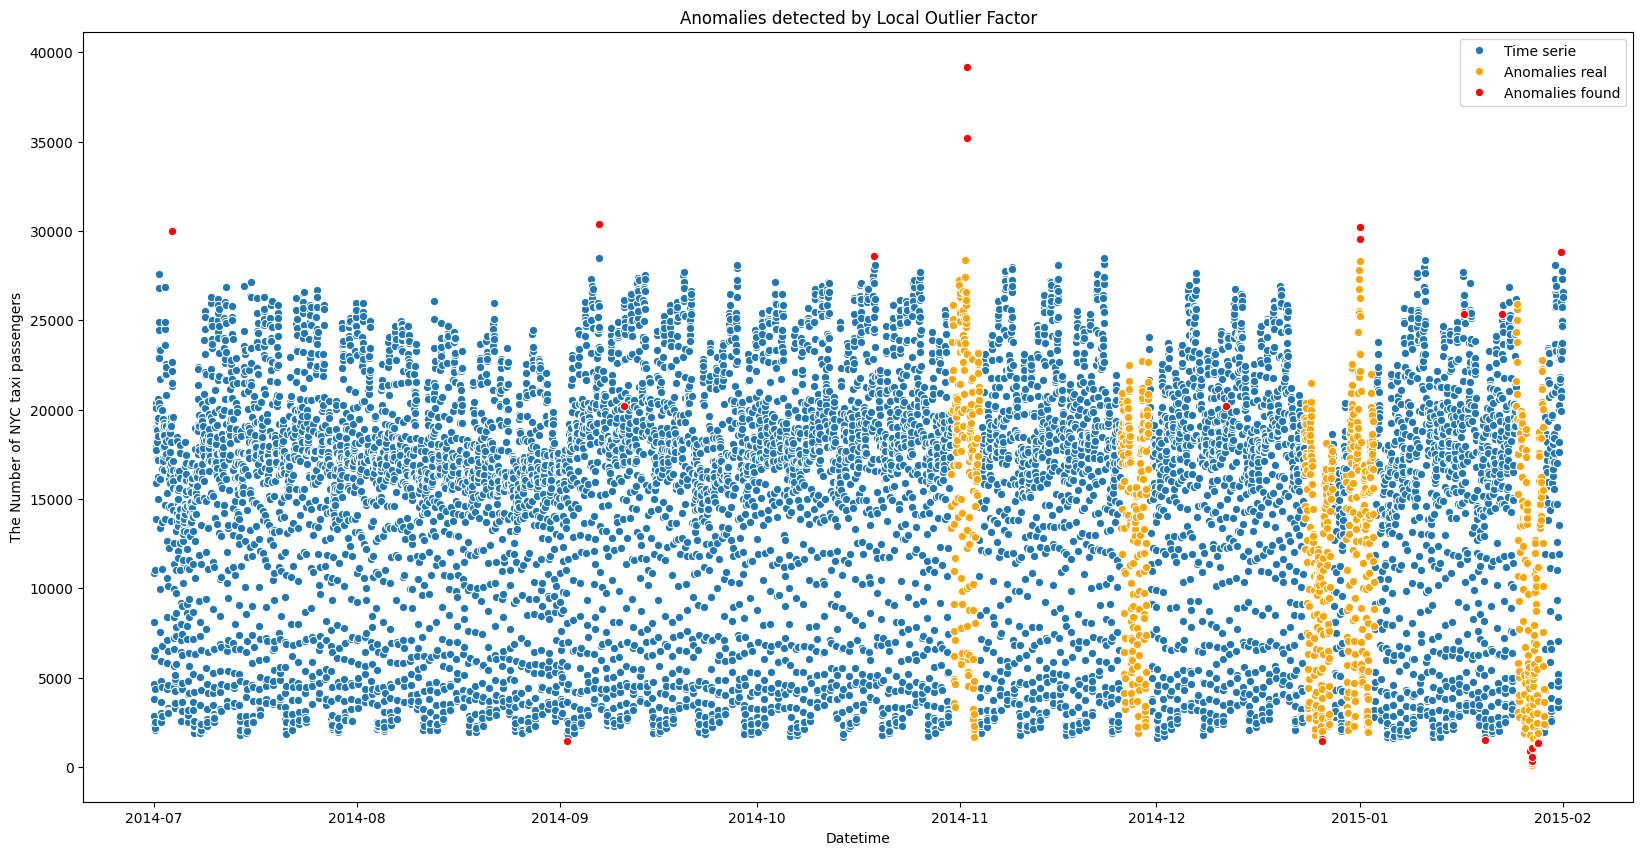

In [16]:
# Display anomalies found
display_anomalies('Local Outlier Factor', 'lof_pred')

### DBSCAN

In [17]:
# Initiate the model optimized
estimator = DBSCAN()

hyper_params = {'eps':[80, 100, 120, 150, 170, 200],
                'min_samples': [40, 50, 60, 80, 100, 150, 200],
                'leaf_size':[20, 30, 40, 50]}

dbscan = optimize(estimator, hyper_params)

# Fit and predict the model
dbscan.fit(df[['value']])
dbscan_pred = dbscan.labels_
print(np.unique(dbscan_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
nan
{'min_samples': 100, 'leaf_size': 50, 'eps': 170}
DBSCAN(eps=170, leaf_size=50, min_samples=100)
[-1  0  1  2  3  4]


c:\Users\Josh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


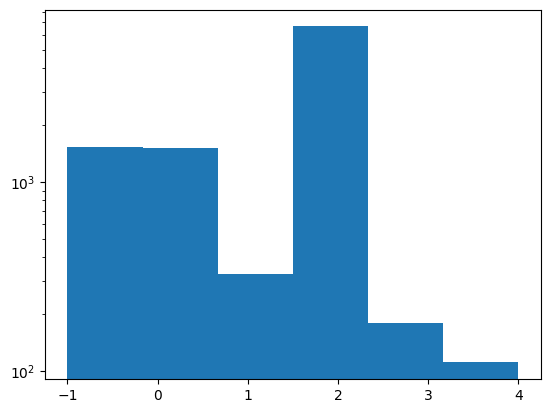

In [18]:
plt.hist(dbscan_pred, bins=len(np.unique(dbscan_pred)), log=True)
plt.show()

In [19]:
n_clusters = len(np.unique(dbscan_pred))-1
anomaly = list(dbscan_pred).count(-1)
print(f'Clusters: {n_clusters}')
print(f'Anormal points: {anomaly}')

Clusters: 5
Anormal points: 1526


In [20]:
df['dbscan_pred'] = [1 if i == -1 else 0 for i in dbscan_pred] # Change the prediction values to make it consistent with the true values

In [21]:
# Evaluate the model
dbscan_silhouette, dbscan_auprc, dbscan_f1 = evaluate('DBSCAN', 'dbscan_pred')

Evaluation for the DBSCAN

Percentage of anoamlies detected : 14.787 %
Percentage of real anomalies : 9.981 %

Silhouette Score : 0.2
AUPRC : 0.12
F1 Score : 0.21

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      9290
           1       0.17      0.25      0.21      1030

    accuracy                           0.80     10320
   macro avg       0.54      0.56      0.55     10320
weighted avg       0.84      0.80      0.82     10320



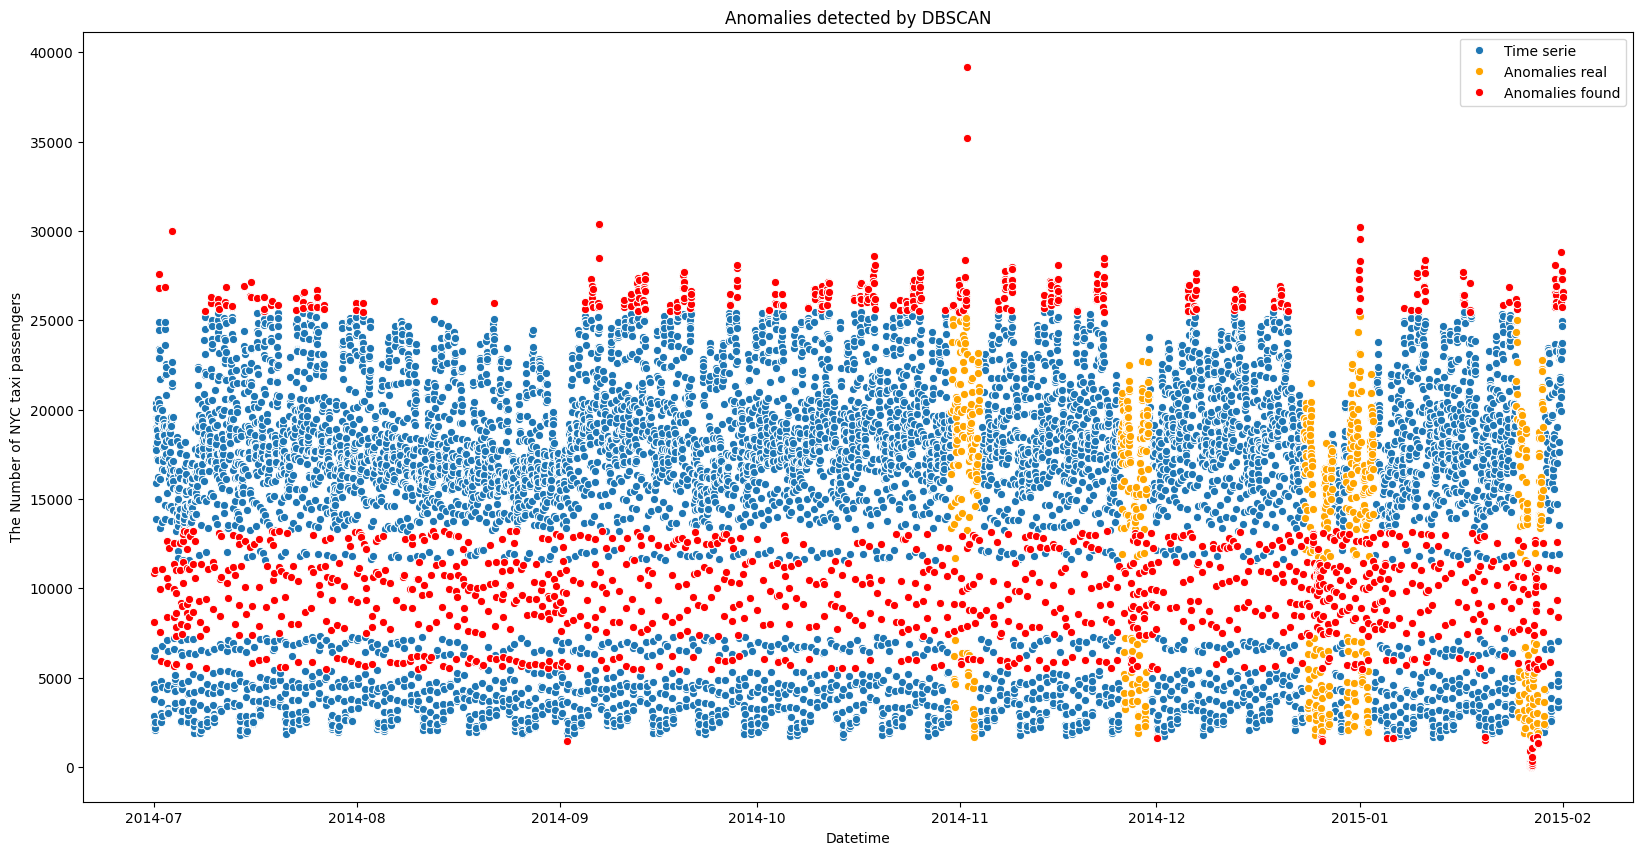

In [22]:
# Display anomalies found
display_anomalies('DBSCAN', 'dbscan_pred')

### Comparaison des modèles

In [23]:
print('Comparaison des mesures des différents modèles')

comparison = pd.DataFrame([[iforest_silhouette, lof_silhouette, dbscan_silhouette],[iforest_auprc, lof_auprc, dbscan_auprc],[iforest_f1, lof_f1, dbscan_f1]],
                            columns=['Isolation Forest','Local Outlier Factor','DBSCAN'],
                            index=[['Silhouette','AUPRC','F1 Score']])

comparison

Comparaison des mesures des différents modèles


,Isolation Forest,Local Outlier Factor,DBSCAN
Silhouette,0.42,0.44,0.20
AUPRC,0.10,0.11,0.12
F1 Score,0.12,0.03,0.21


In [24]:
df

,timestamp,value,class,iforest_pred,lof_pred,dbscan_pred
0,2014-07-01 00:00:00,10844,0,0,0,1
1,2014-07-01 00:30:00,8127,0,0,0,1
2,2014-07-01 01:00:00,6210,0,0,0,0
3,2014-07-01 01:30:00,4656,0,0,0,0
4,2014-07-01 02:00:00,3820,0,0,0,0
...,...,...,...,...,...,...
10315,2015-01-31 21:30:00,24670,0,0,0,0
10316,2015-01-31 22:00:00,25721,0,0,0,1
10317,2015-01-31 22:30:00,27309,0,1,0,1
10318,2015-01-31 23:00:00,26591,0,1,0,1


In [33]:
total = pd.read_csv("../data/total_nyc_taxi.csv",index_col=0)

df = total.copy()

In [34]:
total

,timestamp,value,class,isolationforest_pred,localoutlierfactor_pred,dbscan_pred,autoencoder_pred,lstm_pred,prophet_pred
0,2014-07-01 00:00:00,10844,0,0,0,1,0,0,0
1,2014-07-01 00:30:00,8127,0,0,0,1,0,0,0
2,2014-07-01 01:00:00,6210,0,0,0,0,0,0,0
3,2014-07-01 01:30:00,4656,0,0,0,0,0,0,0
4,2014-07-01 02:00:00,3820,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
10315,2015-01-31 21:30:00,24670,0,0,0,0,0,0,0
10316,2015-01-31 22:00:00,25721,0,0,0,1,0,0,0
10317,2015-01-31 22:30:00,27309,0,1,0,1,0,0,0
10318,2015-01-31 23:00:00,26591,0,1,0,1,0,0,0


In [26]:
evaluate('LSTM', 'lstm_pred')

Evaluation for the LSTM

Percentage of anoamlies detected : 3.256 %
Percentage of real anomalies : 9.981 %

Silhouette Score : 0.14
AUPRC : 0.39
F1 Score : 0.49

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9290
           1       1.00      0.33      0.49      1030

    accuracy                           0.93     10320
   macro avg       0.97      0.66      0.73     10320
weighted avg       0.94      0.93      0.92     10320



(0.14, 0.39, 0.49)